In [2]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from AnalyticCoolingCurves import *
from unpackConfigurations import unpackConfiguration
from unpackConfigurationsMK import unpackConfigurationMK
import ThermalFrontFormulation as TF
from matplotlib.collections import LineCollection
import os
import pickle as pkl
from LRBv2 import LRBv2
from LRBv21 import LRBv21
import matplotlib as mpl
import copy
from LengyelReinkeFormulation import *
import ThermalFrontFormulation as TF
import colorcet as cc
from scipy import interpolate
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter, MultipleLocator, FormatStrFormatter, AutoMinorLocator

from DLScommonTools import *

%load_ext autoreload
%autoreload 2

set_matplotlib_defaults()



# IO

In [113]:
file_paths = {
    "V10" : r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc",
     "V10X" : r"C:\Users\Mike\OneDrive\Project\DLS\from_sarah\V10Xgluedgrid_balance\balance.nc",
     "SPR38" : r"C:\Users\Mike\OneDrive\Project\DLS\STEP_SPR038\drsep0mm\balance_SPR038.nc"}

designs = file_paths.keys()

sepadd = 2
design = "V10X"
eqb = dict()

grid_cases = {"base" : {"res":1000, "log_grid":False},
         "log1k": {"res":1000, "log_grid":True},
         "log100k": {"res":100000, "log_grid":True},
             "5k": {"res":10000, "log_grid":False}}

grids = grid_cases.keys()

for design in designs:
    eqb[design] = dict()
    for case in grids:
        eqb[design][case] = dict()
        for side in ["iu", "ou"]:
            eqb[design][case][side] = unpackConfigurationMK(File = file_paths[design], 
                                                            Type = side, sepadd=sepadd, resolution = grid_cases[case]["res"],
                                                            log_grid = grid_cases[case]["log_grid"])
print("Complete")

Complete


In [4]:
#set switches
radios_default = {
    "ionisation": False,  # in development
    "upstreamGrid": True, #if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, #upstream density
    "nu0" : 1e20,
    "cz0" : 0.02,
    "kappa0" : 2500,
    "mi": 3*10**(-27),
    "echarge": 1.60*10**(-19), 
    "Tt": 0.5, # requested virtual target temp. Aim for low (sub 1eV) Tt
    "Lfunc": LfuncKallenbachAr, #impurity cooling function
    "alpha": 1000, #flux limiting alpha. Only matters if fluxlim is true
}


# Functions

In [114]:
def run_dynamic(grid, store_cases, list_cvars, res):
    store = dict()
    for side in ["iu","ou"]:
        store[side] = dict()
        print("Side {}...".format(side))

        for cvar in list_cvars:
            store[side][cvar] = [0]*len(store_cases)
            print(f"{cvar}")

            for i, case in enumerate(store_cases):
                print("Case", case)

                d = grid[side].copy()
                constants = constants_default.copy()
                radios = radios_default.copy()
                radios["upstreamGrid"] = True
                constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint                
                for key in case.keys():
                    constants[key] = case[key]

                constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
                SparRange = np.linspace(0, d["S"][d["Xpoint"]]*0.99, 7)
                indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]
                constants["Lfunc"] = LfuncKallenbachAr     
                out = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                                    Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                                    control_variable = cvar, dynamic_grid = True, dynamic_grid_res = res)
                store[side][cvar][i] = out    
    return store



In [102]:
def run(grid, store_cases, list_cvars):
    store = dict()
    for side in ["iu","ou"]:
        store[side] = dict()
        print("Side {}...".format(side))

        for cvar in list_cvars:
            store[side][cvar] = [0]*len(store_cases)
            print(f"{cvar}")

            for i, case in enumerate(store_cases):
                print("Case", case)

                d = grid[side].copy()
                constants = constants_default.copy()
                radios = radios_default.copy()
                radios["upstreamGrid"] = True
                constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint                
                for key in case.keys():
                    constants[key] = case[key]

                constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
                SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 7)
                indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]
                constants["Lfunc"] = LfuncKallenbachAr     
                out = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                                    Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                                    control_variable = cvar)
                store[side][cvar][i] = out    
    return store

s = dict()

list_cvars = ["density"]
store_cases = [{"qpllu0":0.25e9},
               {"qpllu0":1.0e9}]
design = "SPR38"


Side iu...
density
Case {'qpllu0': 250000000.0}
Solving...0...40...67...84...93...99...104...

C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv21.py:62: RuntimeWarning: invalid value encountered in double_scalars
  dtds = qoverB*fieldValue/(kappa0*T**(5/2))
C:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Complete in 10.6 seconds
Case {'qpllu0': 1000000000.0}
Solving...0...40...67...84...

C:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


93...99...104...Complete in 10.9 seconds
Side ou...
density
Case {'qpllu0': 250000000.0}
Solving...0...110...187...258...306...331...340...Complete in 9.6 seconds
Case {'qpllu0': 1000000000.0}
Solving...0...110...187...258...306...331...340...Complete in 9.2 seconds


In [126]:
s["dyn1k"] = run_dynamic(eqb[design]["5k"], store_cases, list_cvars, res = 1000)

Side iu...
density
Case {'qpllu0': 250000000.0}
Solving...

TypeError: int() argument must be a string, a bytes-like object or a number, not 'tuple'

In [ ]:
s["base"] = run(eqb[design]["base"], store_cases, list_cvars)

In [103]:
s["log100k"] = run(eqb[design]["log100k"], store_cases, list_cvars)

Side iu...
density
Case {'qpllu0': 250000000.0}
Solving...0...43102...46821...48457...49226...49631...49999...Complete in 42.6 seconds
Case {'qpllu0': 1000000000.0}
Solving...0...43102...46821...48457...49226...49631...49999...Complete in 41.1 seconds
Side ou...
density
Case {'qpllu0': 250000000.0}
Solving...0...43282...46473...48380...49396...49838...49999...Complete in 41.1 seconds
Case {'qpllu0': 1000000000.0}
Solving...0...43282...46473...48380...49396...49838...49999...Complete in 41.8 seconds


In [14]:
store_labels = dict()
store_labels["cvar"] = {"density" : "$n_{u}\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}$"}
store_labels["crel"] = {"density" : "$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ /\ q_{\parallel0} (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}\ /\ f_{z0}$"}

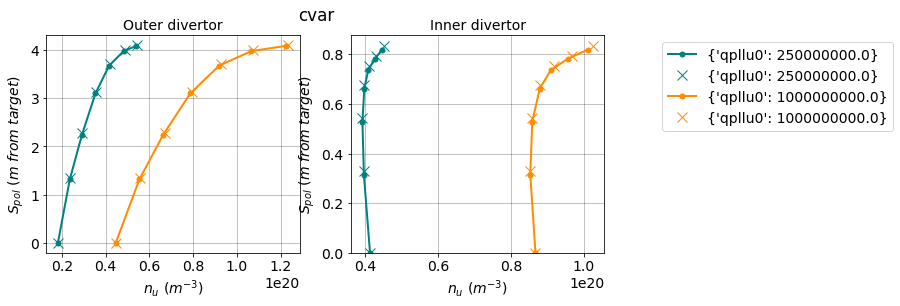

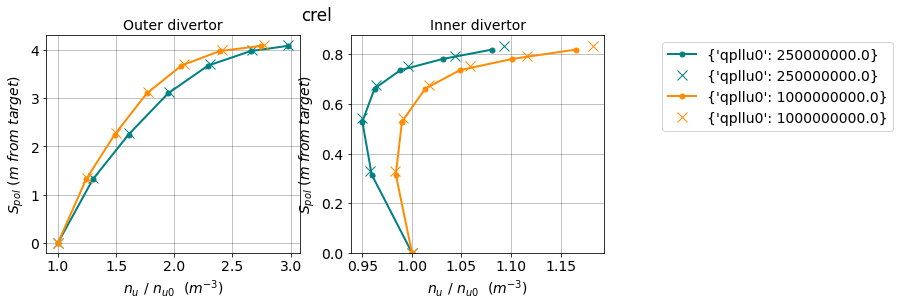

In [105]:
colors = mike_cmap(3)

basis = "cvar"
cvar = "density"

for basis in ["cvar", "crel"]:
    fig, axes = plt.subplots(1,2, figsize = (10,4))
    fig.suptitle(basis)
    ax = axes[0]

    
    cases = o
    for k, case in enumerate(store_cases):
        for i, side in enumerate(["ou", "iu"]):

            o = s["base"][side][cvar].copy()
            axes[i].plot(o[k][basis], o[k]["SpolPlot"],  marker = "o", label = case, markersize = 5, linewidth = 2, color = colors[k])
            o = s["log100k"][side][cvar].copy()
            axes[i].plot(o[k][basis], o[k]["SpolPlot"],  marker = "x", label = case, markersize = 10, linewidth = 0, color = colors[k])


    ylims = axes[1].get_ylim()
    axes[1].set_ylim(0,ylims[1])

    for ax in axes:
        ax.grid(color ="black", alpha = 0.3)
        ax.set_xlabel(store_labels[basis][cvar])
        ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")

    axes[0].set_title("Outer divertor")
    axes[1].set_title("Inner divertor")
    axes[1].legend(bbox_to_anchor=(1.2,1))

    # legend_elements = [mpl.lines.Line2D([0], [0], color=colors[0], lw=3, label='V10'),
    #                    mpl.lines.Line2D([0], [0], color=colors[1], lw=3, label="V10X"),
    #                    mpl.lines.Line2D([0], [0], color=colors[2], lw=3, label="SPR38"),
    #                    # mpl.lines.Line2D([0], [0], color= "black", linestyle = "dashed", lw=0, marker = "o", label="Log grid 1k"),
    #                    mpl.lines.Line2D([0], [0], color= "black", linestyle = "dotted", lw=3, marker = "x", label="Log grid 100k")]

    # axes[1].legend(handles = legend_elements)


In [110]:
def plot_rad(o,d, relative = False):
    fig, ax = plt.subplots(figsize=(8,6))
    cmap = plt.get_cmap("plasma")
    colors = make_colors(len(o["Tprofiles"]), cmap)   

    for i, Tprofile in enumerate(o["Tprofiles"]):
        ax.plot(o["Sprofiles"][i], Tprofile, color = "black", linewidth = 1)

        x = o["Sprofiles"][i]
        y = Tprofile
        
        if relative == False:
            norm = mpl.colors.LogNorm(2e6, 1.5e9)
            z = np.array(o["Rprofiles"][i])
        else:
            norm = mpl.colors.LogNorm(0.01, 1)
            z = np.array(o["Rprofiles"][i])/np.nanmax(np.array(o["Rprofiles"][i]))
            
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap='nipy_spectral', norm=norm)
        lc.set_array(z)
        lc.set_linewidth(5)
        lc.set_zorder(10)
        line = ax.add_collection(lc)

    ylims = ax.get_ylim()
    ax.vlines(0, ylims[0], ylims[-1], zorder = 0, label = "target", color = "black",alpha = 0.3, linewidth = 3)
    ax.vlines(d["S"][d["Xpoint"]], ylims[0], ylims[-1], zorder = 0, label = "Xpoint", color = "black",alpha = 0.3, linewidth = 3, linestyle = "dashed")
    
    if relative == False:
        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap("nipy_spectral")),  orientation="vertical", label = "Radiated power (W/m3)")
    else:
        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap("nipy_spectral")),  orientation="vertical", label = "Radiated power (% of peak)")
        
    cb.ax.set_yticklabels(["{:.2E}".format(i) for i in cb.get_ticks()]) 

    ax.legend(loc="lower right")
    ax.grid(color = "black", alpha = 0.2)
    ax.set_xlabel("Spar (m) from target to midplane")
    ax.set_ylabel("Temperature (eV)")
    ax.set_title("Temperature profiles for scan of front locations")
    # o = qscan[side]["density"][q_choice]
    # d = eqb[side][design]
    # plot_norm_rad(o, d)

C:\Users\Mike\AppData\Local\Temp/ipykernel_15296/1598616361.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(["{:.2E}".format(i) for i in cb.get_ticks()])


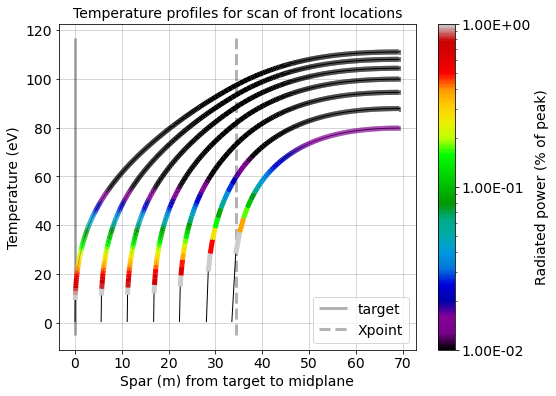

In [111]:
side = "ou"
relative = True
case = "base"
plot_rad(s[case][side]["density"][0], eqb[design][case][side], relative = relative)

# case = "log100k"
# plot_rad(s[case][side]["density"][0], eqb["V10X"][case][side], relative = relative)